<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# *[Machine Learning Tutorial](https://github.com/wikistat/MLTraining)* 
# Segmentation d'une image multispectrale
## Représenter la diversité géologique de la surface de Mars
### Utilisation de la librairie <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a> en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> 


### Résumé
La segmentation d'image est un exemple typique de classification non-supervisée (*clustering*). Après une visualisation des données (spectres) et une exploration par [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) (ACP), différentes stratégies de classification non supervisée sont appliquées, précédées ou non d'une réduction de dimension par ACP : [$k$-*means*, ascendante hiérarchique](http://wikistat.fr/pdf/st-m-explo-classif.pdf), [mélanges gaussiens](http://wikistat.fr/pdf/st-m-datSc4-EMmixt.pdf). Les résultats fournissent une segmentation de l'image assimilable à une carte géologique de la surface de Mars. Cette carte peut être comparée avec celle établie par des experts mais à partir des mêmes données. Il reste difficile de déterminer quelle métode ou stratégie conduit à la une "meilleure" segmentation de l'image. 

## 1 Introduction
### 1.1 Les données
Les données sont constituées d'une image hyperspectrale de la surface de Mars. L'imagerie visible et en proche infra-rouge est une technique clef de télédétection pour étudier le système planétaire à l'aide de spectromètres embarqués sur des satellites. En mars 2014, l'équipement OMEGA (Mars Express, ESA, Bibring et. al. 2005) a collecté 310 GO d'images brutes. Il a cartographié la surface de Mars avec une résolution variant entre 300 et 3000 m foncton de l'altitude du véhicule spatial. Il a acquis, pour chaque pixel, la réponse spectrale présente entre 0.36 et 5.2 μm et échantillonnées dans 255 canaux. L'objectif est de caractériser la composition matérielle de la surface et en particulier de distinguer différentes classes de silicates, minéraux, oxides, carbonates et parties gelées. 

Ceci est illustré par l'analyse d'une image 300 × 128. A chacun de ces 38 400 pixels, individus, instances ou unités statistiques est associée un vecteur de 255 valeurs spectrales ou variables, caractéristiques ou features.  

### 1.2 Objectif
Selon les experts, il y a *K = 5* classes minéralogiques à identifier sur la carte. L'objectif est donc d'opérer une classification non supervisée des pixels conduisant à une segmentation de l'image en 5 types ou (fausses) couleurs des pixels. Avant d'opérer la segmentation, une approche exploratoire permet de se familiariser avec ce type particulier de données. Bouveyron (2017) propose d'utiliser une approche sur la base de mélanges de modèles gaussiens associés à une sélection de variables pour réduire la dimension (*High Dimensional Gaussian Mixture Model*). Nénamoins, d'autres algorithmes plus rudimentaires peuvent être employés.

**Bibring J.P. et al.** (2005). Mars Surface Diversity as Revealed by the OMEGA/Mars Express Observations, *Science*, Vol. 307, Issue 5715, pp. 1576-1581.

**Bouveyron C.** (2017). Model-based Clustering of High-Dimensional Data in Astrophysics, *Statistics for Astrophysics: Clustering and Classification*, D. Fraix-Burnet and S. Girard (eds,)EAS Publications Series, 77 (2016) 91–119.

## 2 Exploration
Ne pas bâcler cette phase préliminaire d'exporation. Elle est essentielle pour détecter des  incohérences, valeurs atypiques, données manquantes... tout problème lié notamment à l'acquisition des données. Les données étudiées dans cet exemple sont évidemment *a priori* de bonne qualité mais il serait très naïf de penser que c'est toujours le cas. 
### 2.1 Lecture des données
**NB** Pyhton lit directement l'archive `mars.csv.zip` sans la décompresser au préalable.

In [1]:
# Principales librairies
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster as sclust
from scipy import cluster
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import numpy as np
import random
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
mars = pd.read_csv("mars.csv.zip")
n_pixel = mars.shape[0]
dim_spectral = mars.shape[1]
# Dimensions de l'image
n_pixel_x = 300
n_pixel_y = 128
dim_spectral

255

Vérifier la bonne lecture du fichier.

In [3]:
summary = mars.describe()
summary.transpose

<bound method DataFrame.transpose of                  V1            V2            V3            V4            V5  \
count  38400.000000  38400.000000  38400.000000  38400.000000  38400.000000   
mean       0.373672      0.408012      0.418404      0.420980      0.421814   
std        0.098974      0.080131      0.080369      0.081863      0.081315   
min        0.038469      0.233688      0.259045      0.269580      0.273937   
25%        0.299668      0.334763      0.343065      0.345050      0.344962   
50%        0.365481      0.388543      0.397193      0.399102      0.399245   
75%        0.445685      0.487916      0.502658      0.507322      0.508697   
max        0.832065      0.590190      0.580816      0.579686      0.580050   

                 V6            V7            V8            V9           V10  \
count  38400.000000  38400.000000  38400.000000  38400.000000  38400.000000   
mean       0.421358      0.426807      0.429181      0.419277      0.418314   
std        0.0

### 2.2 Description élémentaire
Distribution de la variable associée à une longueur d'onde particulière.

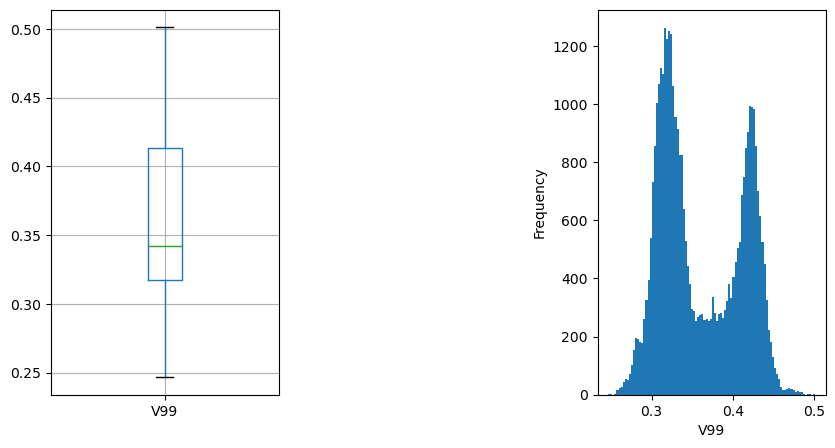

In [4]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
mars.boxplot('V99')     # mètode de pandas Dataframe.
plt.subplot(1, 3, 3)
plt.hist(mars['V99'], bins = 100) # histograma usant una columna del df i nombre donat de bins.
plt.xlabel("V99")
plt.ylabel("Frequency")
plt.show()

**Q** Commentaires: symmétrie, dispersion, multi-modalité?

Distributions de toutes les variables / longueurs d'onde dans un même graphique. 

És important realitzar-la per observar com evoluciona la variança dels individus (instàncies) al llarg de les variables (eix x)

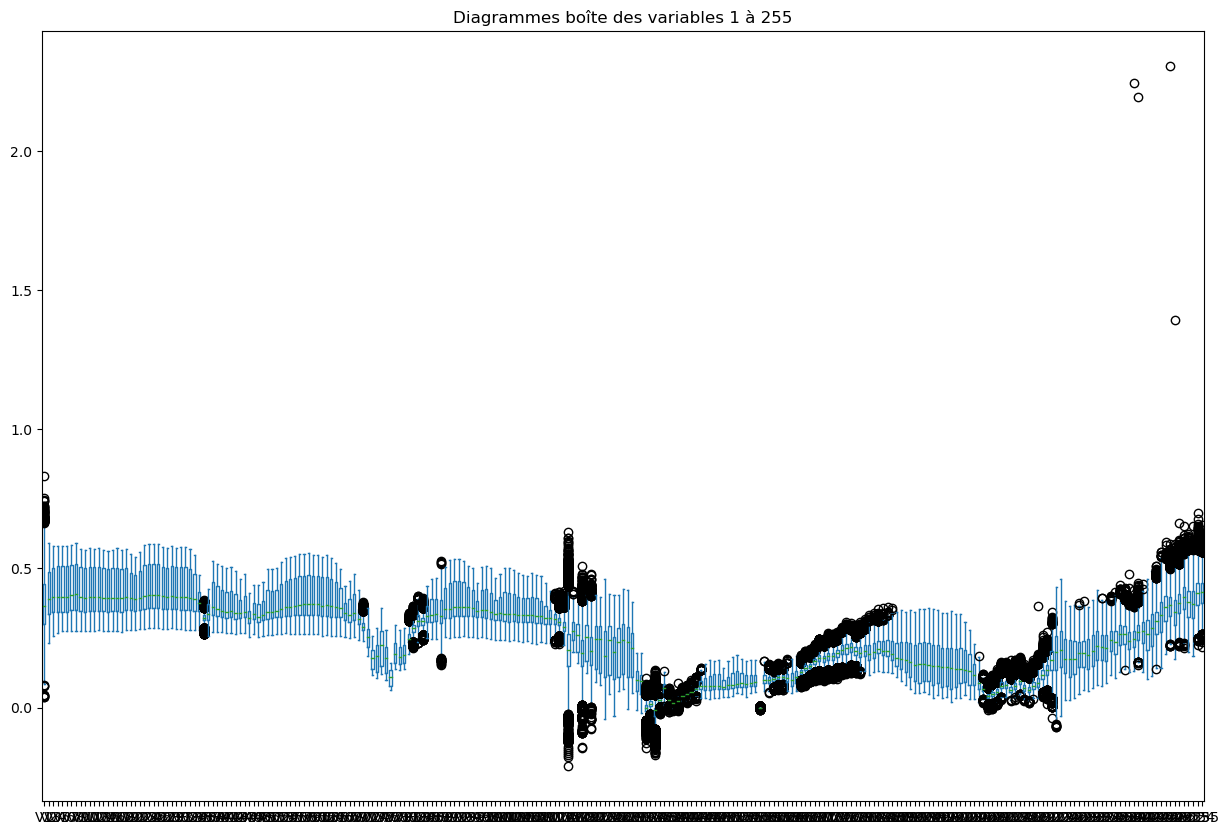

In [5]:
mars[mars.columns[0:255]].plot(kind = "box",figsize = (15, 10))
plt.title("Diagrammes boîte des variables 1 à 255")
plt.show()

**Q** Commentaires: symétrie, étendue des boîtes, valeurs atypiques.

Représentation des spectres d'un sous-échantillon de pixels.

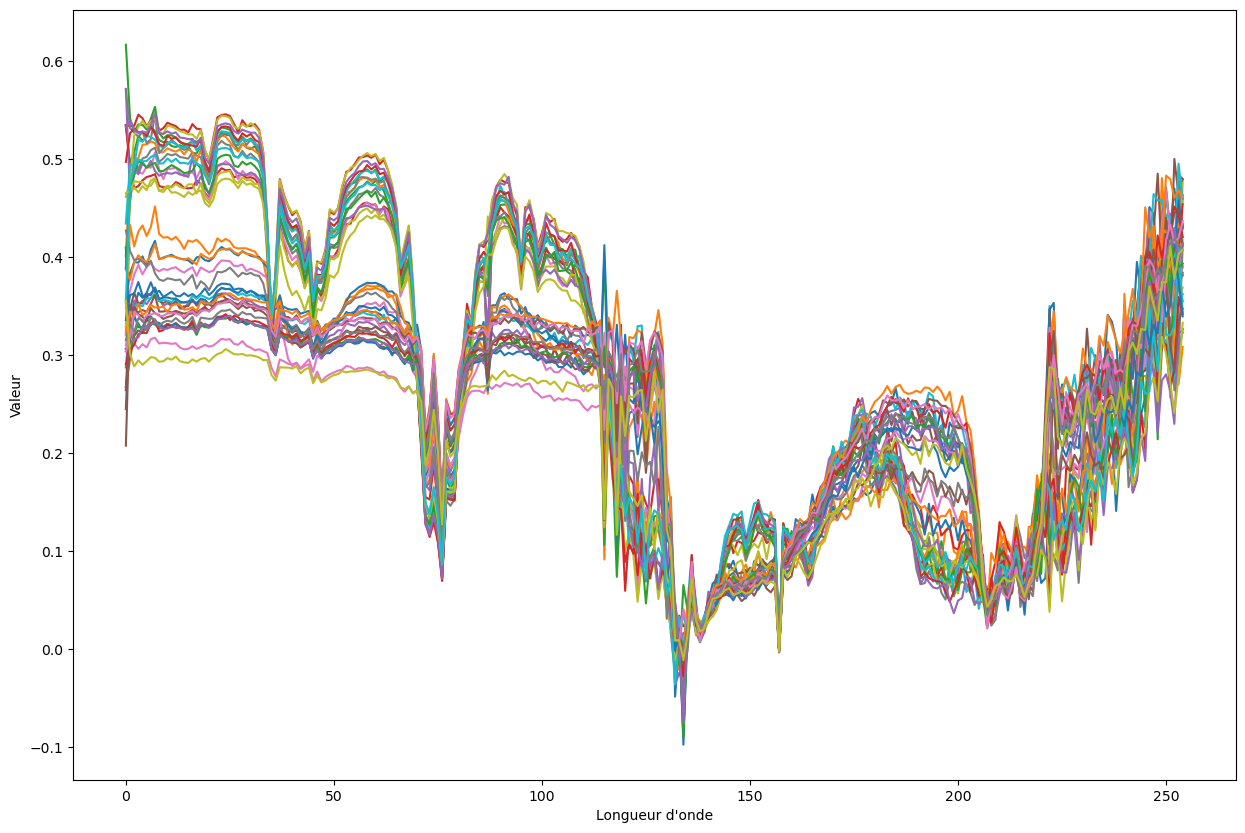

In [6]:
plt.figure(figsize = (15, 10))
echantillon=mars[::1000] #échallion = mostra estadística
x=np.arange(0, 255)

for i in range(0, np.shape(echantillon)[0]):
    plt.plot(x, echantillon.values[i,:])  
plt.ylabel('Valeur')
plt.xlabel("Longueur d'onde")
plt.show()

**Q** Commentaires: différentes zones ou intervalles de longueurs d'ondes, régularité des spectres, synchronisation des pics, multi-modalité.

### 2.2 [Analyse en Composantes Principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) (ACP)

Visualisation de l'ensemble des spectres par projection sur les premiers axes. Compte tenu de la disparité des variances des variables, l'ACP est réduite.

In [7]:
#définition de la commande
pcaR = PCA()
marsR = pd.DataFrame(scale(mars), columns = mars.columns)
#composantes principales
C = pcaR.fit(marsR).transform(marsR)

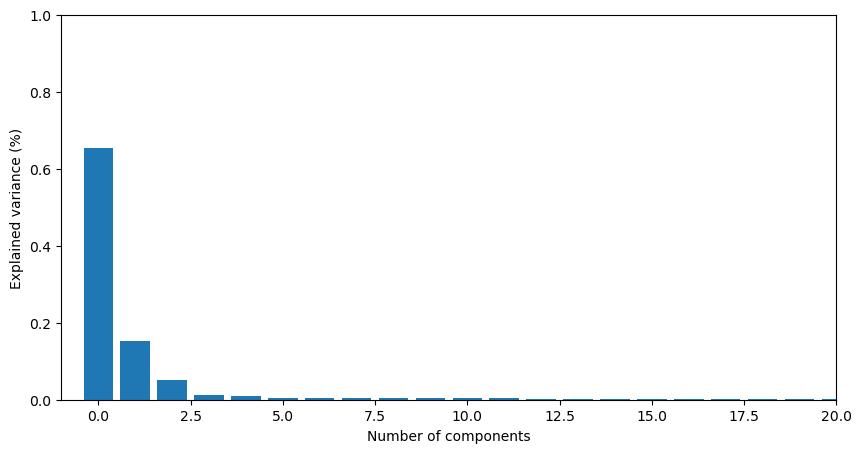

In [8]:
plt.figure(figsize = (10,5))
x=np.arange(pcaR.explained_variance_ratio_.size)
plt.bar(x, pcaR.explained_variance_ratio_)
plt.axis((-1, 20, 0, 1))
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.show()

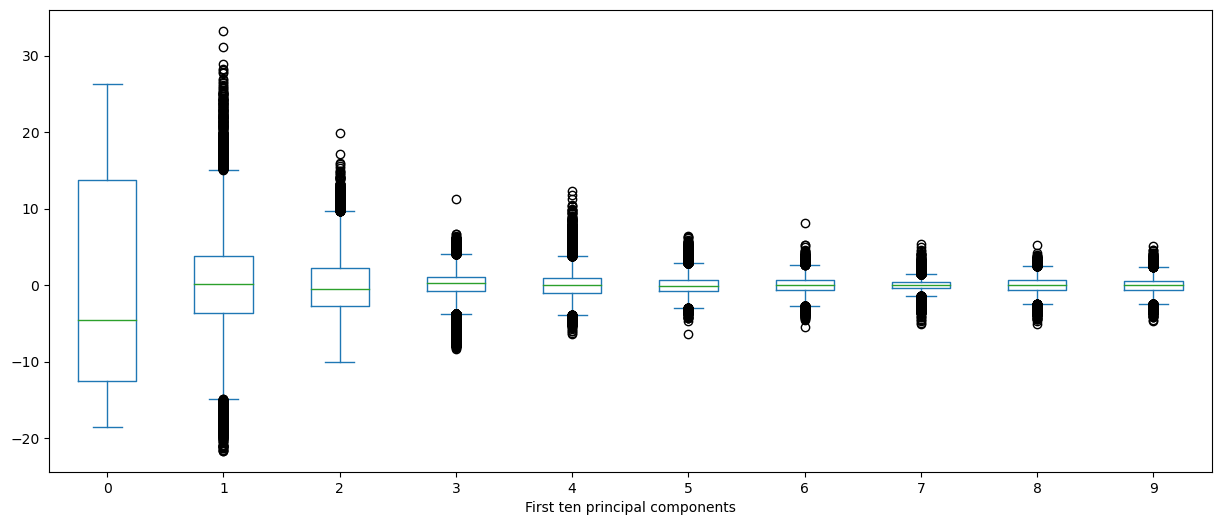

In [9]:
pd.DataFrame(C[:,0:10]).plot(kind = "box", figsize = (15, 6) )
plt.xlabel('First ten principal components')
plt.show()

**Q** Que sont ces graphiques? Quel choix de dimension?

Représentation des variables / longueurs d'onde


Podem veure que (gairebé) tots els punts tenen valors positius per a la pc0. 

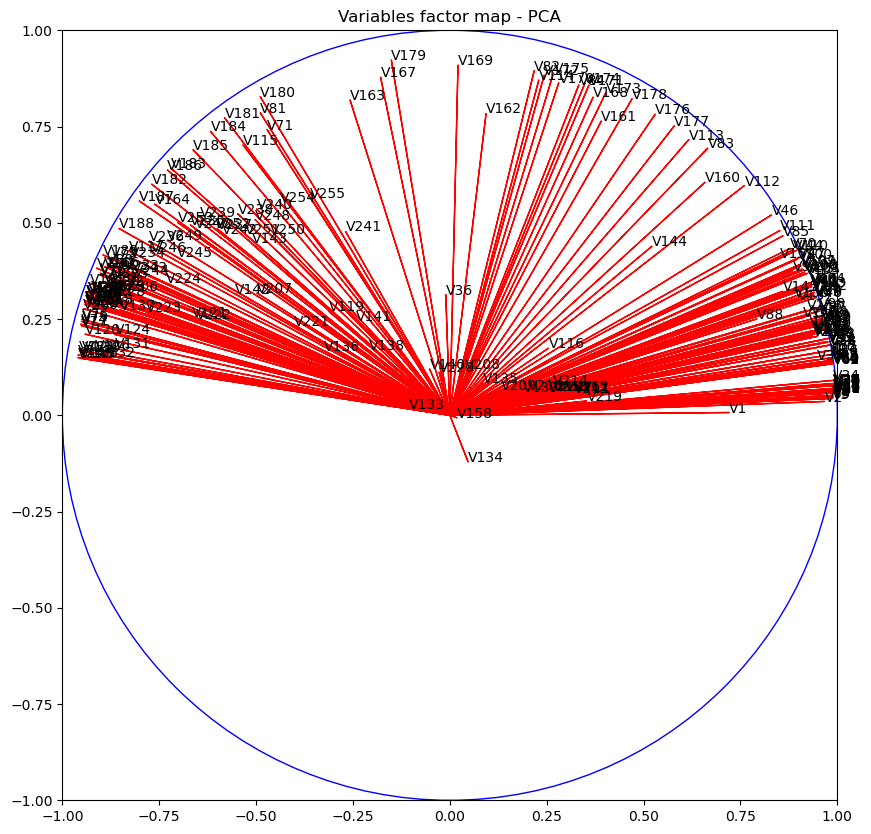

In [10]:
coord1 = pcaR.components_[0] * np.sqrt(pcaR.explained_variance_[0])
coord2 = pcaR.components_[1] * np.sqrt(pcaR.explained_variance_[1])
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord2, marsR.columns):
    plt.text(i, j, nom)
    plt.arrow(0, 0, i, j, color = 'r', width = 0.0001)
plt.axis((-1, 1, -1, 1))
#Cercle
c = plt.Circle((0, 0), radius = 1, color = 'b', fill = False)
ax.add_patch(c)
plt.title('Variables factor map - PCA')
plt.show()

**Q** Commentaires sur la structure de corrélation, la qualité de représentation.

Représentation des individus / pixels de l'image.... C'est un peu long à cause du nombre de points. 

No podem observar 5 clusters (objectiu de l'estudi) ni de broma: hi ha massa punts massa acumulats com per veure tipus de roca a través dels punts.

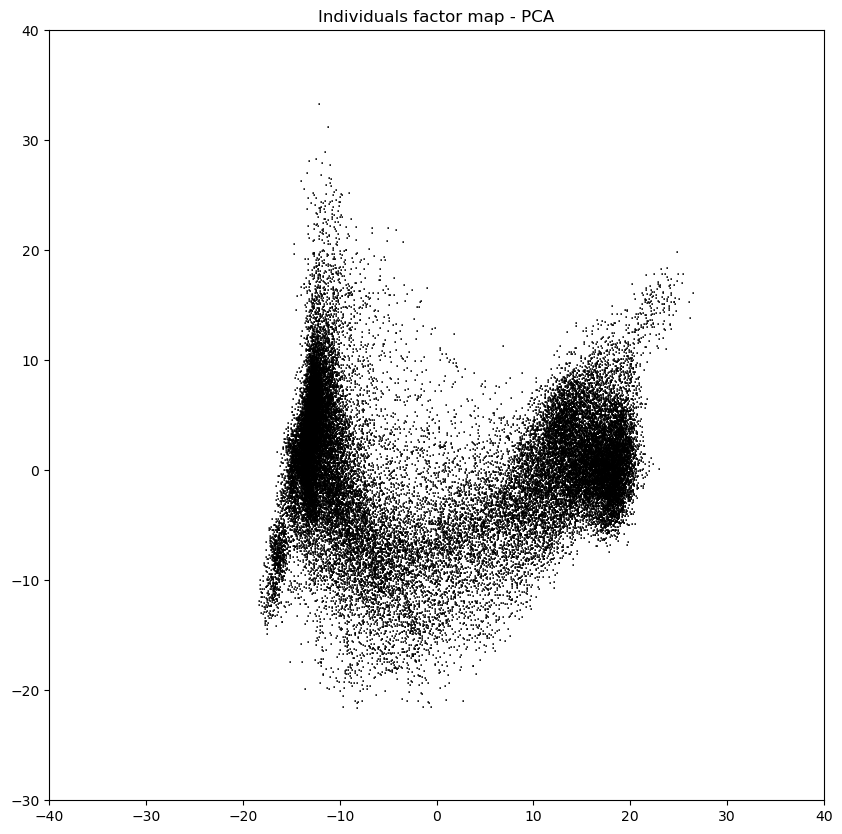

In [11]:
pc1 = C[:,0]
pc2 = C[:,1]
plt.figure(figsize = (10, 10))
for i, j in zip(pc1, pc2):
    plt.text(i, j, ".")
plt.axis((-40, 40, -30, 40))
plt.title('Individuals factor map - PCA')
plt.show() #els eixos son x=pc0 i y=pc1

**Q** Commentaires sur la forme, la structure, du nuage.

Représentation des 8 premières fonctions propres.

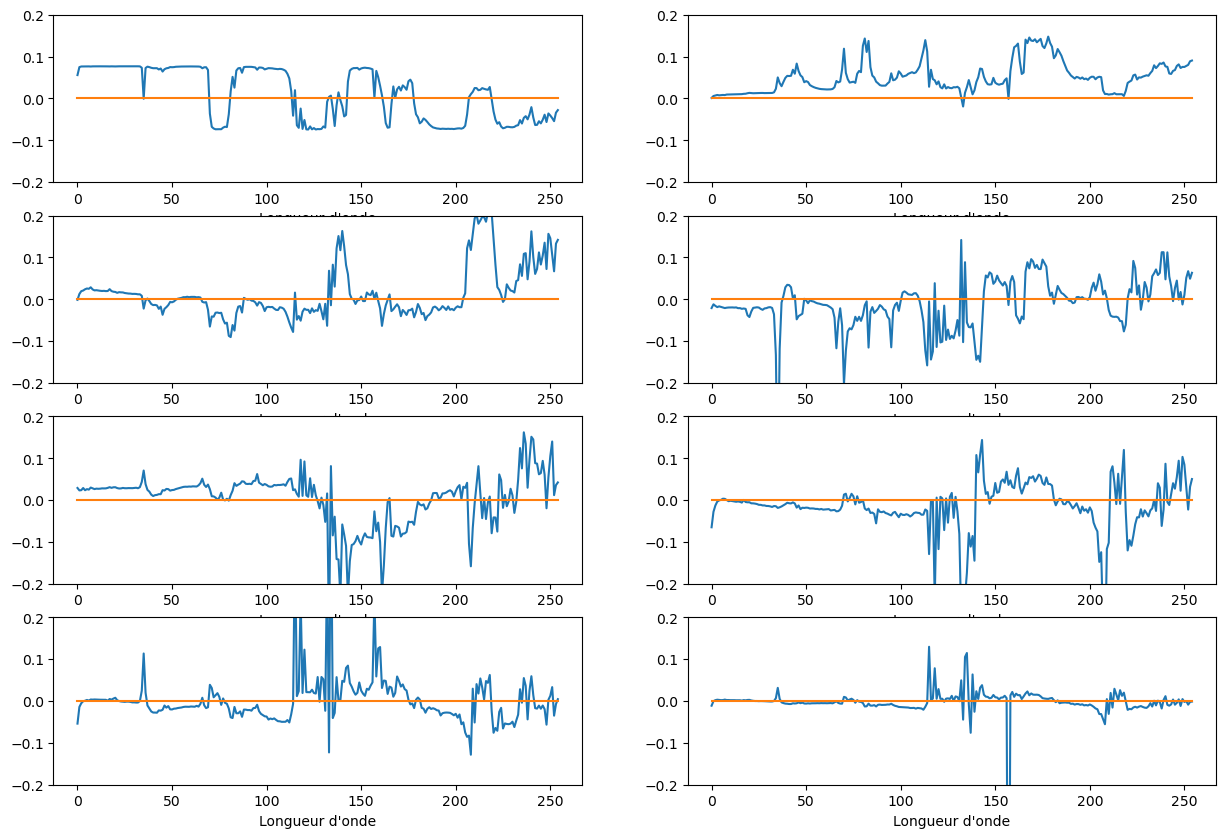

In [12]:
fig = plt.figure(1, figsize = (15, 10))
x = np.linspace(0, 254, 255)
for i in range(0, 8):
   fig.add_subplot(4, 2, i+1)
   plt.ylim((-0.2, 0.2))
   plt.plot(x, pcaR.components_[i])
   plt.plot(x, [0] * len(x))
   plt.xlabel("Longueur d'onde")
plt.show()

**Q** Commentaire sur la relative régularité de premières fonctions propres. Sur les bandes du spectre que chaque composante met en évidence.

Reconstruction des spectres sur la base des 3 premières fonctions propres. Remarquez la nécessité de rajouter moyenne et écart-type global puisque l'ACP a été faite sur les données centrées et réduites.

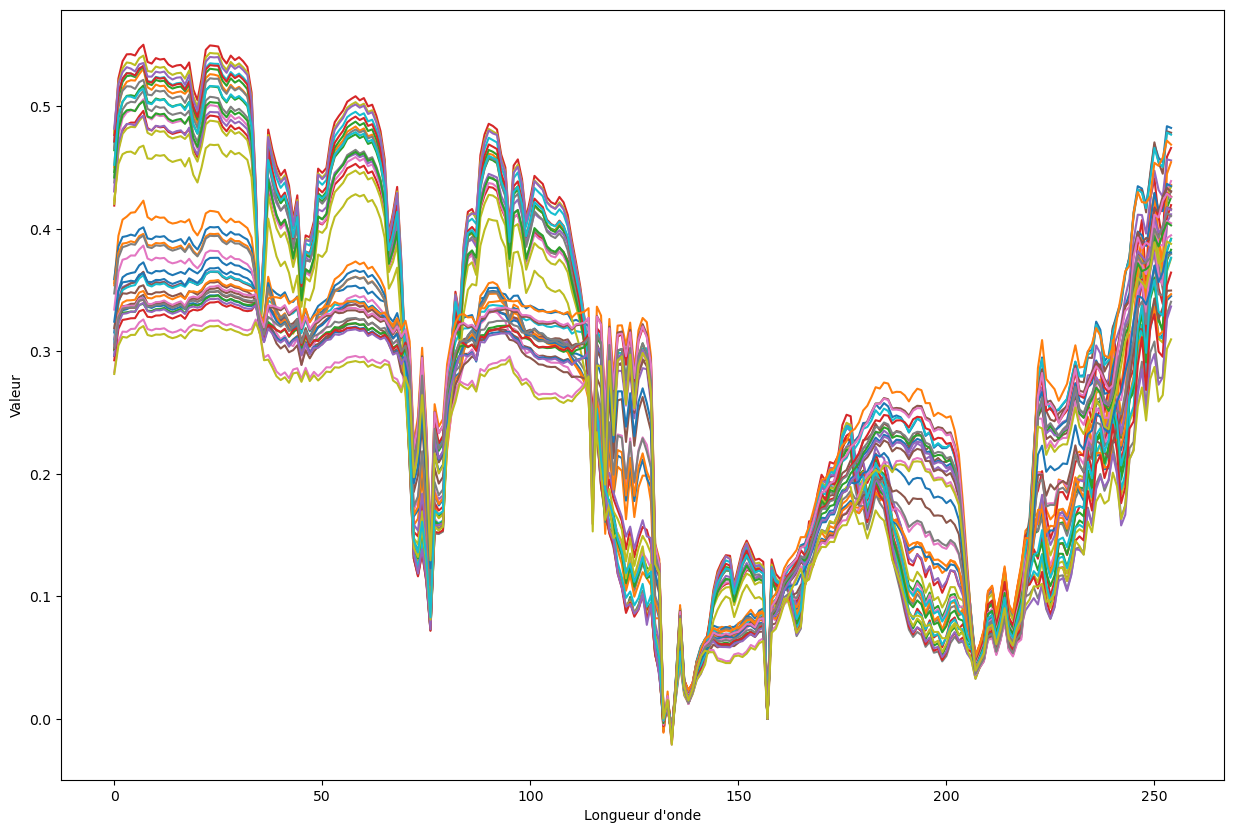

In [13]:
plt.figure(figsize = (15, 10))
globalMean = pd.DataFrame(mars, columns = mars.columns).mean()
globalSd = pd.DataFrame(mars, columns = mars.columns).std()
x = np.arange(0,255)
for i in range(0, np.shape(mars)[0], 1000):
    yScale = C[i,0] * pcaR.components_[0] + C[i, 1] * pcaR.components_[1] + C[i, 2] * pcaR.components_[2]
    y = globalMean + globalSd * yScale
    plt.plot(x, y)  
plt.ylabel('Valeur')
plt.xlabel("Longueur d'onde")
plt.show()

## 3 Classifications non supervisées et segmentation de l'image

### 3.1 Librairies et fonctions supplémentaires

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from matplotlib import colors

La fonction `illustration` représente l'image (chaque pixel) en fausse couleur, celle identifiée par la classe du pixel.

In [15]:
def illustration(classe):
    #classe : vecteur ligne qui contient les numeros des classes
    mars_scale_v1 = classe
    mars_image = mars_scale_v1.reshape((n_pixel_x, n_pixel_y))
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow'])
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mars_image, interpolation = 'nearest', cmap = cmap, aspect = 'auto')
    plt.show()

La fonction `illustrationCouleur` opère une permutation sur les numéros de classe de façon à faire correspondre au mieux les classes trouvées par deux méthodes de classifications.

In [16]:
def illustrationCouleur(classe1, classe2):
    table = pd.crosstab(classe1, classe2, 
                        rownames = ['classes '], colnames = ['classes données brutes'])
    a = [0, 0, 0, 0, 0] 
    b = [0, 0, 0, 0, 0]
    for j in range (0, 5):
        for i in range (0, 5):
            if (a[j] < table[i][j]):
                a[j] = table[i][j]
                b[j] = i
    print ("")
    print ("max colonne", a)
    print ("j=", b)
    print ("")
    classe = np.copy(classe1)
    for i in range (0, np.shape(classe1)[0]):
        for j in range(0, np.shape(table)[0]):
            if (classe1[i] == j):
                classe[i] = b[j]
    return classe

La fonction ` crossTable` permet de créer une table croisée comparant deux classifications. Lignes et colonnes sont réordonnées pour obtenir les cellules d'effectif maximum sur la diagonale.

In [17]:
def crossTable(classe1, classe2):
    """"
    Confusion matrix between 2 classes.
    """
    table = pd.crosstab(classe1, classe2, 
                        rownames = ['classes ACP'], colnames = ['classes données brutes'])
    a = np.zeros(np.shape(table)[0])
    b = np.zeros(np.shape(table)[0])
    for j in range (0, np.shape(table)[0]):
        for i in range (0, np.shape(table)[0]):
            if (a[j] < table[i][j]):
                a[j] = table[i][j]
                b[j] = i                       
                                             
    print ("")
    print ("max colonne", a)
    print ("j=", b)
    print ("")
    tablebis = np.copy(table)
    for i in range (0, np.shape(table)[0]):
        tablebis[i][:] = table[b[i]][:]        
    return tablebis

La fonction `courbeWave` représente graphiquement les pixels (différentes courbes) en fonction des longueurs d'onde (axe des abscisses); la couleur de chaque courbe est déterminée par la classe.

La fonction `difference` compare deux images et affiche en blanc les pixels n'appartenant pas à la même classe.

In [18]:
def difference(classe1, classe2):
    c = np.zeros(np.shape(classe1)[0])
    compteur = 0
    for i in range (0, np.shape(classe1)[0]):
        if not(classe1[i] == classe2[i]):
            c[i] = 6
            compteur = compteur + 1
        else:
            c[i] = classe1[i]
    print("le ratio est de :")   
    print( compteur / np.shape(classe1)[0])
    print("nb pixels classés différemment : ", compteur)
    mars_scale_v1 = c
    mars_image = mars_scale_v1.reshape((n_pixel_x, n_pixel_y))

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'white'])

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mars_image, interpolation = 'nearest', cmap = cmap, aspect = 'auto')
    plt.show()

### 3.2 Classification par réallocation dynamique: $k$-*means*

**Q** Quelles sont les principales caractéristiques de l'algorithme $k$-*means* vis à vis de la taille des données traitées, du choix du nombre de classes ?

Deux stratégies sont comparées : classification des pixels caractérisés par les trois premières composantes de l'ACP puis par le spectre complet.

#### Sur les composantes de l'ACP
**Attention** La réduction de dimension opérée par l'ACP induit des propriétés qui peuvent s'avérer intéressantes ou pas. Dans le cas présent, se restreindre aux trois premières composantes agit comme un débruitage ou filtre passe-bas car les fonctions propres associées aux petites valeurs propres sont particulièrement bruitées. Ce peut être utile dans le cas présent mais peut s'avérer nuisible dans d'autres circonstances ; en particulier lorsque des séparation de classes ou groupes sont à rechercher dans des directions associées à des petites variances. Le choix de la distance entre les objets, ici des courbes, est de toute façon fondamentale. 

Les graphes liés à l'ACP de décroissance des valeurs propres suggèrent de conserver trois composantes. Il serait possible d'en conserver plus. 

Exécution de l'algorithme en fixant le nombre de classes et représentation sommaire des effectifs. 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

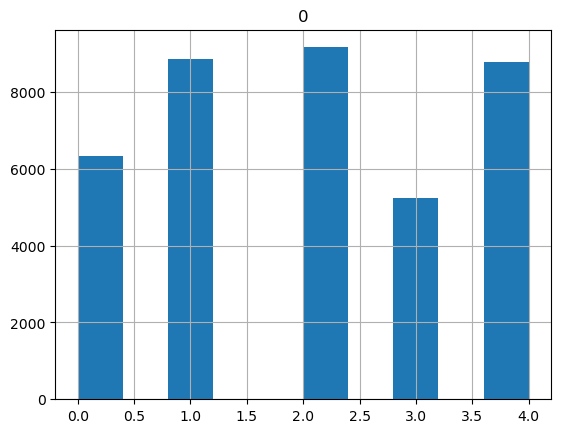

In [19]:
marsCP = C[:,0:3] # trois premières composantes
kmeans = KMeans(n_clusters = 5, random_state = 0, n_init = 10).fit(marsCP)
kclassesACP = kmeans.labels_
# effectifs des classes
pd.DataFrame(kclassesACP).hist()

#### Sur les données initiales ou toutes les composantes
**Attention** il est très généralement recommander de réduire les variables avant de lancer un algorithme de classification non supervisée.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

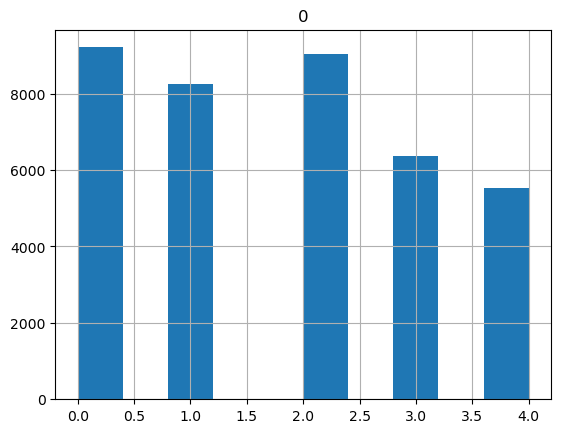

In [20]:
kmeans=KMeans(n_clusters = 5, random_state = 0, n_init = 10).fit(marsR)
kclasses = kmeans.labels_
pd.DataFrame(kclasses).hist()

La comparaison des deux classifications n'est pas immédiate car les classes n'ont pas le même numéro. Nénamoins la fonction `crossTable` y rémédie d'une certaine façon.

In [21]:
crossTable(kclassesACP, kclasses)


max colonne [6225. 8480. 9114. 5154. 8233.]
j= [3. 2. 0. 4. 1.]



array([[6225,    0,   52,   87,    0],
       [   0, 8480,    0,    1,  554],
       [  94,    0, 9114,    6,    0],
       [  21,  355,    0, 5154,    4],
       [   2,   18,    0,    0, 8233]])

Ainsi que la fonction `illustrationCouleur` qui renumérote les classes.

In [22]:
random.randint(1,7)

1


max colonne [6225, 8480, 9114, 5154, 8233]
j= [3, 2, 0, 4, 1]



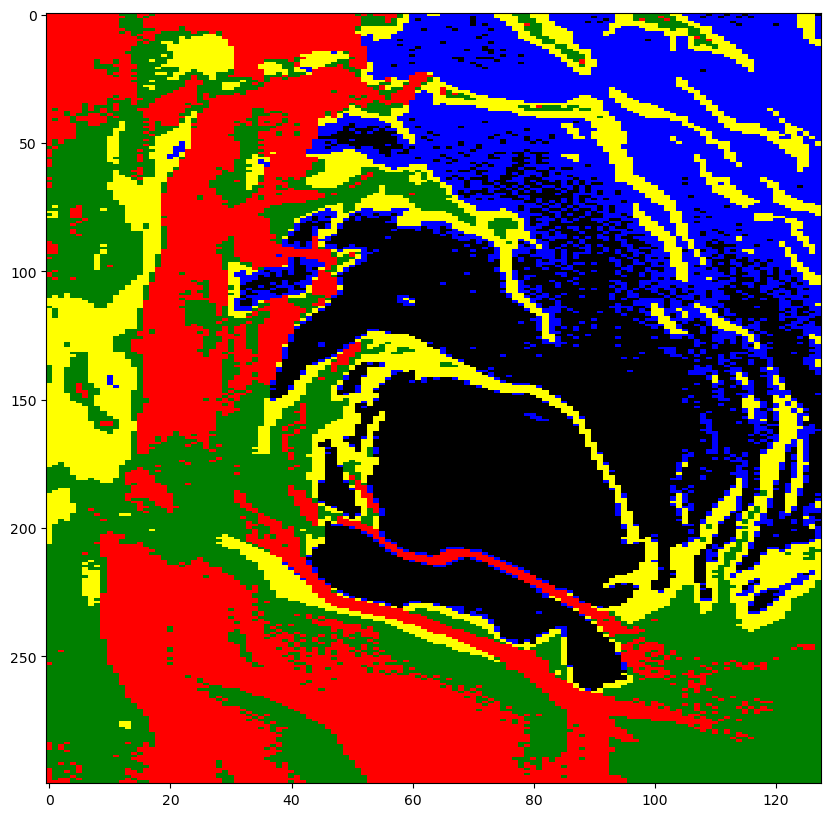

In [23]:
kclassesACPcouleur = illustrationCouleur(kclassesACP, kclasses)
illustration(kclassesACPcouleur)

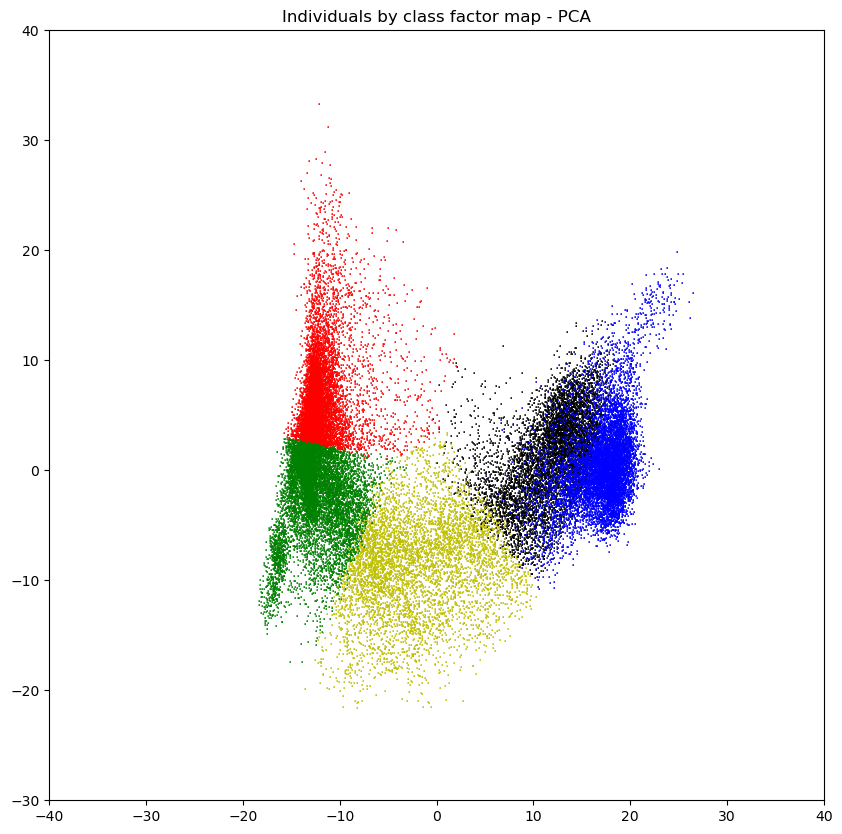

In [24]:
pc1 = C[:,0]
pc2 = C[:,1]
coul = ['b', 'r', 'g', 'k', 'y']
plt.figure(figsize = (10, 10))
for i, j, indcoul in zip(pc1, pc2, kclasses):
    plt.text(i, j, ".", color = coul[indcoul])
plt.axis((-40, 40, -30, 40))
plt.title('Individuals by class factor map - PCA')
plt.show()

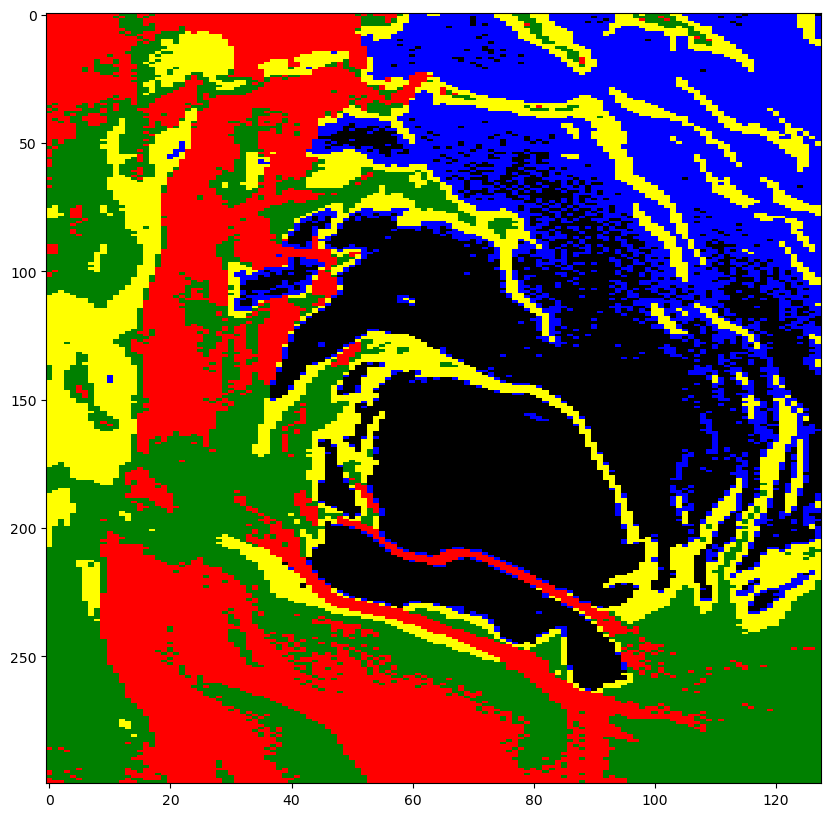

In [25]:
illustration(kclasses)

Il est finalement plus facile de préciser la comparaison en affichant en blanc les pixels ayant changé de classe.

le ratio est de :
0.03109375
nb pixels classés différemment :  1194


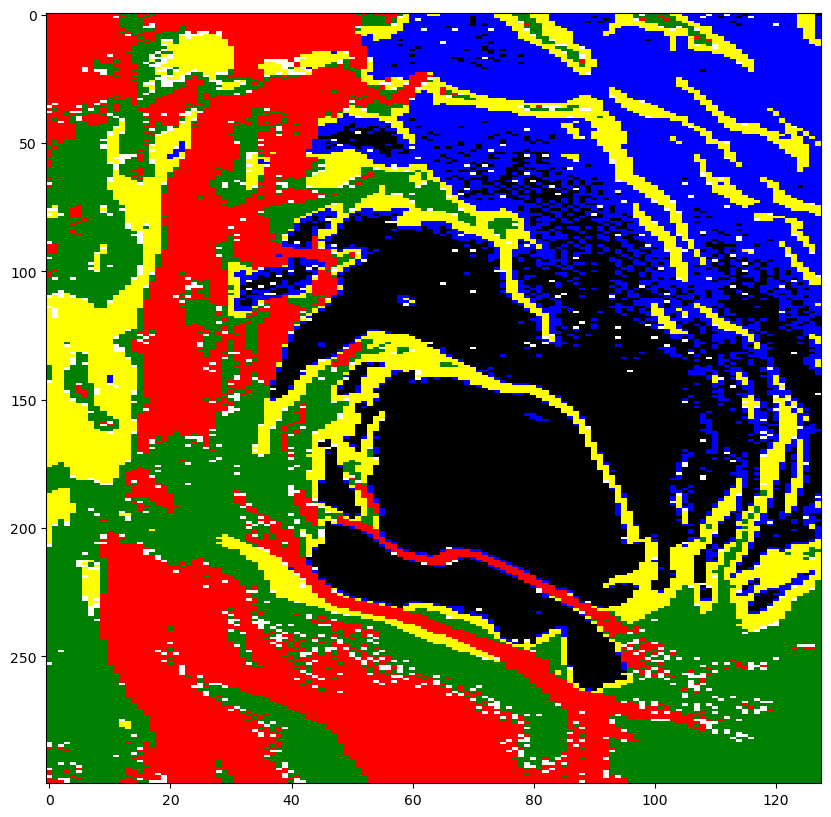

In [26]:
difference(kclasses, kclassesACPcouleur)

**Q** Que dire des segmentations obtenues avant ou après une ACP? Serait-il possible de d'opérer un choix entre les deux?

Un expert géologue pourrait identifier les classes à l'aide des représentations des spectres associés aux classes ou plutôt aux barycentres de ces classes.

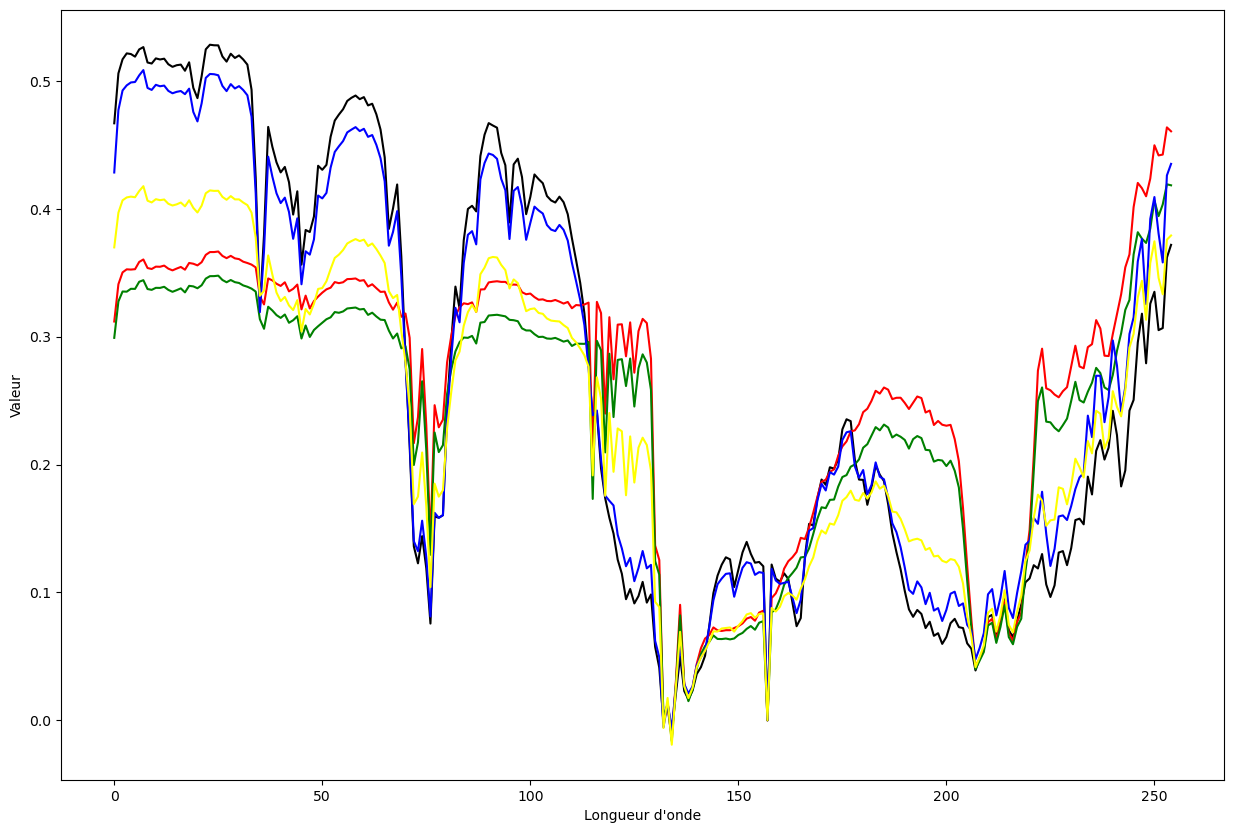

In [27]:
plt.figure(figsize = (15,10))
x = np.arange(0, 255)
couleur = ['black', 'red', 'green', 'blue', 'yellow']
for i in range(0,5):
    coul = couleur[i]
    y = np.mean(mars[kclasses == i], axis = 0) # calcul des barycentres des classes.
    plt.plot(x, y, coul) 
plt.ylabel('Valeur')
plt.xlabel("Longueur d'onde")
plt.show()

### 3.3 Classification ascendante hiérarchique (CAH) 
L'algorithme $k$-*means* conduit à des résultats satisfaisants. Ceux-ci sont comparés avec ceux issus d'autres approches. L'algorithme DBSCAN est d'exécution très longue et comme les résultats ne sont pas probants, il a été abandonné. 

#### CAH d'un sous-échantillon
**Q** Comment se comporte la CAH vis-à-vis de la taille des données, du nombre de classes ?

La classification peut être lancée sur tous les pixels mais, dans un premier temps, l'algorithme est exécuté sur un échantillon de taille raisonnable pour faciliter les représentations.

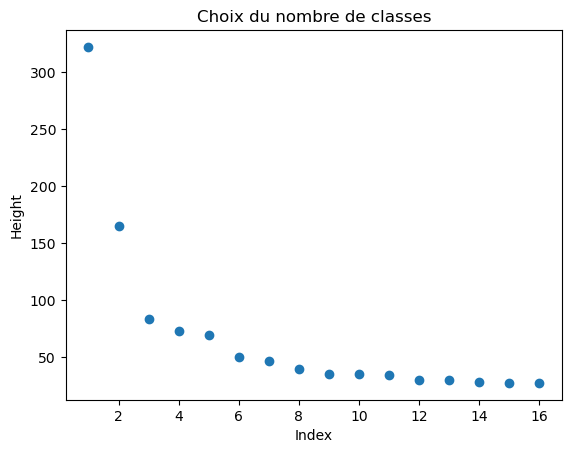

In [28]:
marsRech = marsR[::100] # Tirage d'un sous-échantillon des pixels
Z = linkage(marsRech, 'ward', metric = 'euclidean') # choix de la distance
height = Z[:, 2]  # Décroissance des sauts
x = np.arange(16) + 1
height = sorted(height, reverse = True)
plt.scatter(x, height[0:16])  #height[0:16]/sum(height[0:16])*100
plt.xlabel('Index')
plt.ylabel('Height')
plt.title("Choix du nombre de classes")
plt.show()

Aqui tenim dos punts on podríem parar: a 3 o a 6, que son els canvis de pendents. Amb 3 tindríem classes que agruparien 2+ tipus de roca

**Q** Quel est ce graphique ? Quels choix possibles du nombre de classes ?

**Remarque**: l'avis à suivre des géologues est qu'il faut de toute façon chercher 5 classes !

Affichage du dendrogramme.

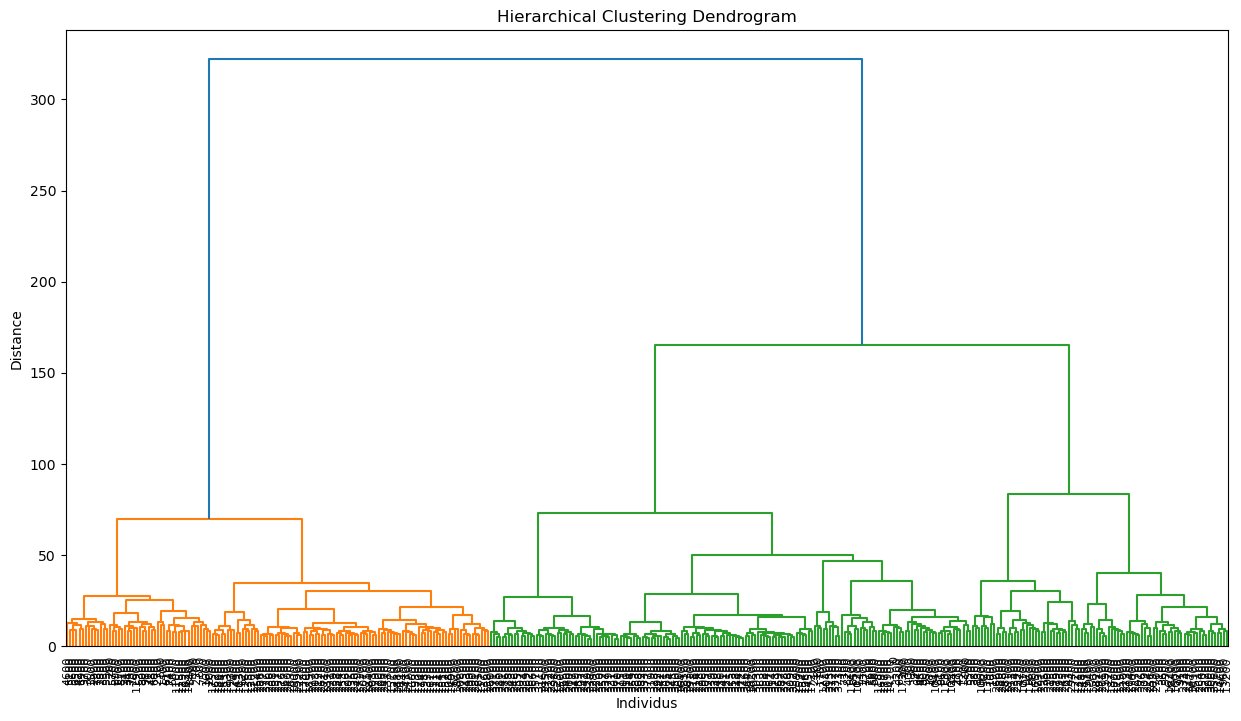

In [29]:
plt.figure(figsize = (15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Individus')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size = 8., labels = marsRech.index)
plt.show()

Couper l'arbre à `t = 72` conduit à sélectionner 5 classes.

**Q** Que dire de l'utilisation de ce paramètre `t` permettant de couper le dendrogramme et donc de sélectionner le nombre de classes?

In [30]:
classesCAH = fcluster(Z, t = 72, criterion = 'distance')

Effectifs des classes.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

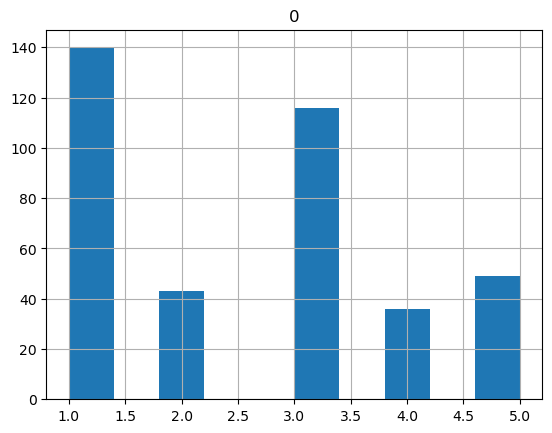

In [31]:
pd.DataFrame(classesCAH).hist()

Représentation des classes dans le plan de l'ACP

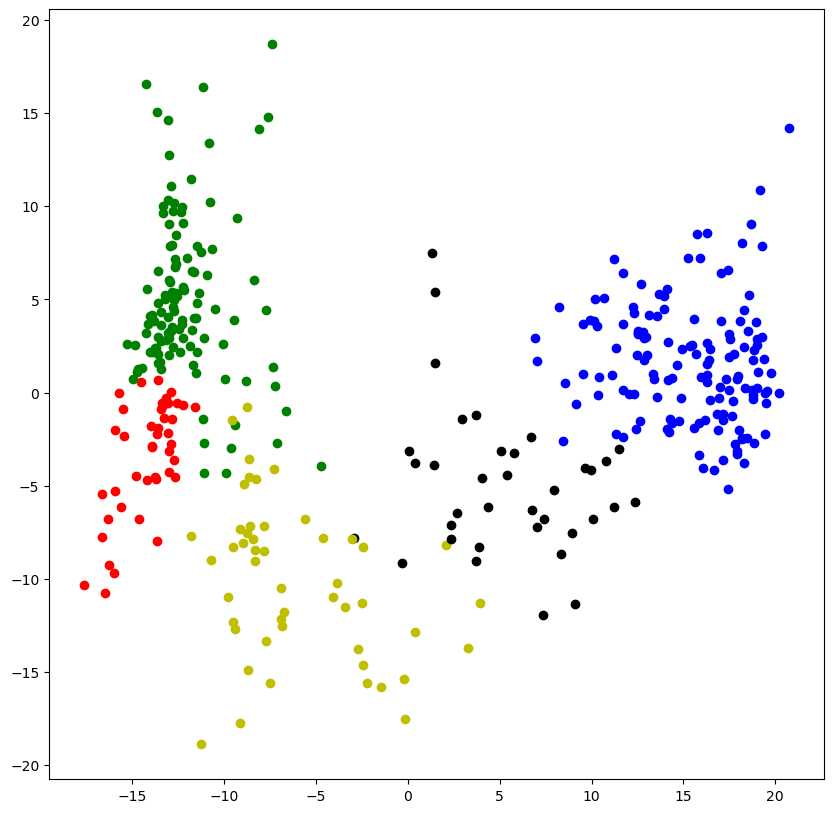

In [32]:
echantillon1 = C[::100,0]
echantillon2 = C[::100,1]
coul = ['b', 'r', 'g', 'k', 'y']
plt.figure(figsize = (10, 10))
for i, j, nom, indcoul in zip(echantillon1, echantillon2, 
                              np.linspace(1, np.shape(C[::100,:])[0], 
                                          num=np.shape(C[::100,:])[0]), classesCAH):
    plt.scatter(i, j, c = coul[indcoul - 1])
#plt.axis((-2,2,-1,1))  
plt.show()

#### CAH de l'ensemble des pixels

Le même algorithme de CAH est exécuté sur l'ensemble des pixels. 

**Attention** Le temps d'exécution augmente très sensiblement.

In [33]:
Z2 = linkage(marsR, 'ward', metric = 'euclidean')

**Q** Quelles autres options de la CAH sont possibles?

Nombre de classes puis dendrogramme.

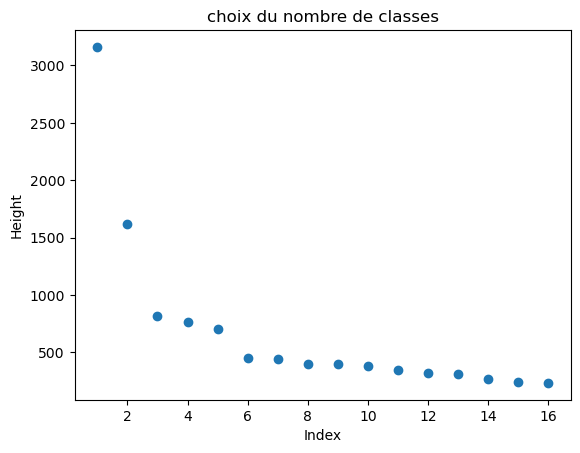

In [34]:
height = Z2[:, 2]
x = np.arange(16) + 1
height = sorted(height, reverse=True)
plt.scatter(x, height[0:16])
plt.xlabel('Index')
plt.ylabel('Height')
plt.title("choix du nombre de classes")
plt.show()

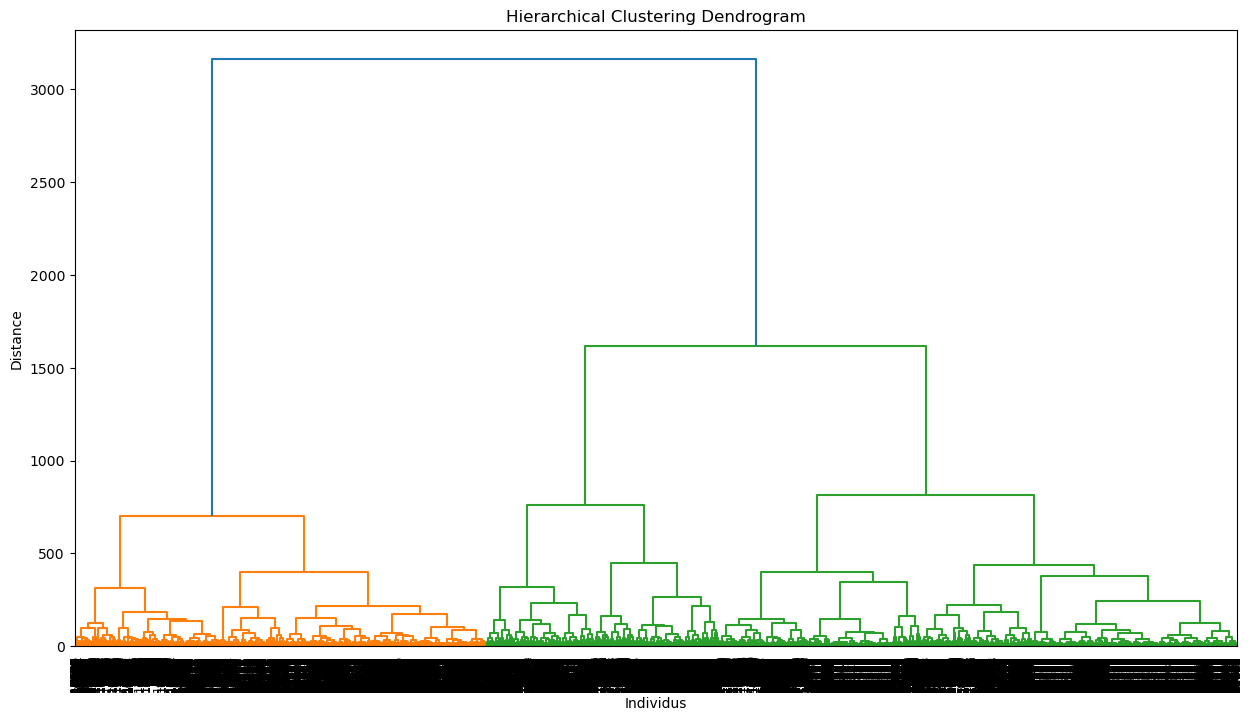

In [35]:
plt.figure(figsize = (15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Individus')
plt.ylabel('Distance')
dendrogram(Z2, leaf_font_size = 8., labels = mars.index)
plt.show()

No és gens obvi trobar el coi de 5 classes. Si establim el 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

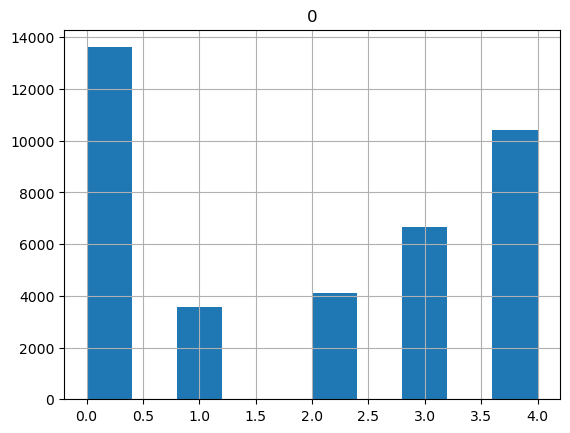

In [36]:
classesCAH = fcluster(Z2, t = 750, criterion='distance')
classesCAH = classesCAH - 1
pd.DataFrame(classesCAH).hist()

Comparaison avec $k$-*means*.

In [37]:
crossTable(classesCAH, kclasses)


max colonne [8607. 2862. 2032. 6415. 8052.]
j= [0. 4. 4. 1. 2.]



array([[8607,    0,  607,    0,    0],
       [  30, 2862, 2032,    0,  610],
       [  30, 2862, 2032,    0,  610],
       [   0,    0,   85, 6415, 1753],
       [   0,  718,    2,  263, 8052]])

Les deux segmentations issus de $k$-*means* et la CAH sont trop différentes pour des comparaisons directes. Les couleurs ne peuvents être correctement réassociées. 

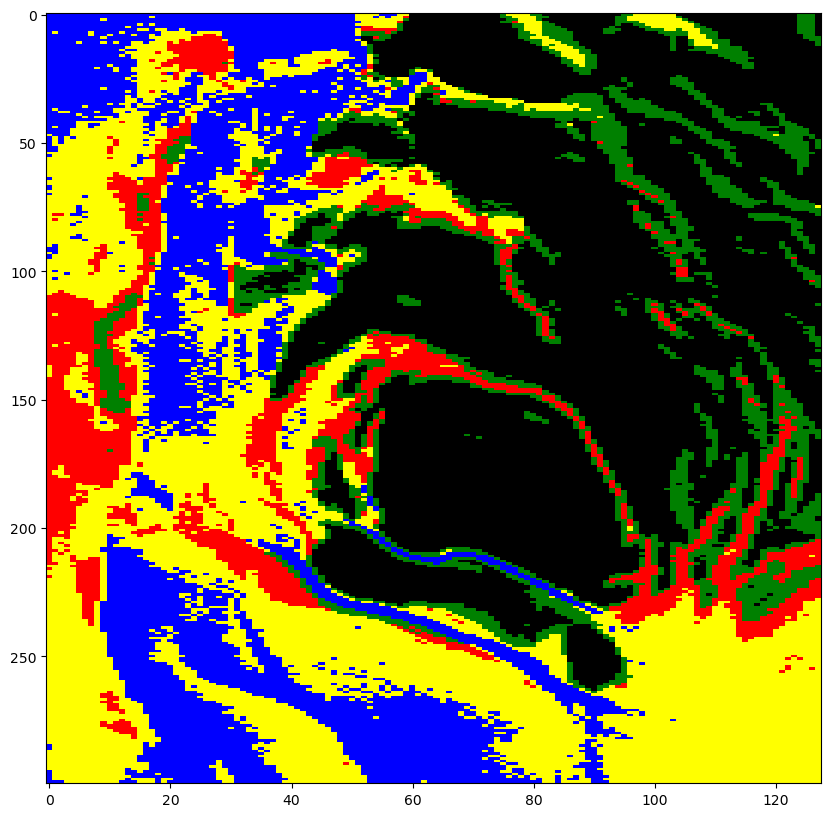

In [38]:
illustration(classesCAH)

Barycentres des classes.

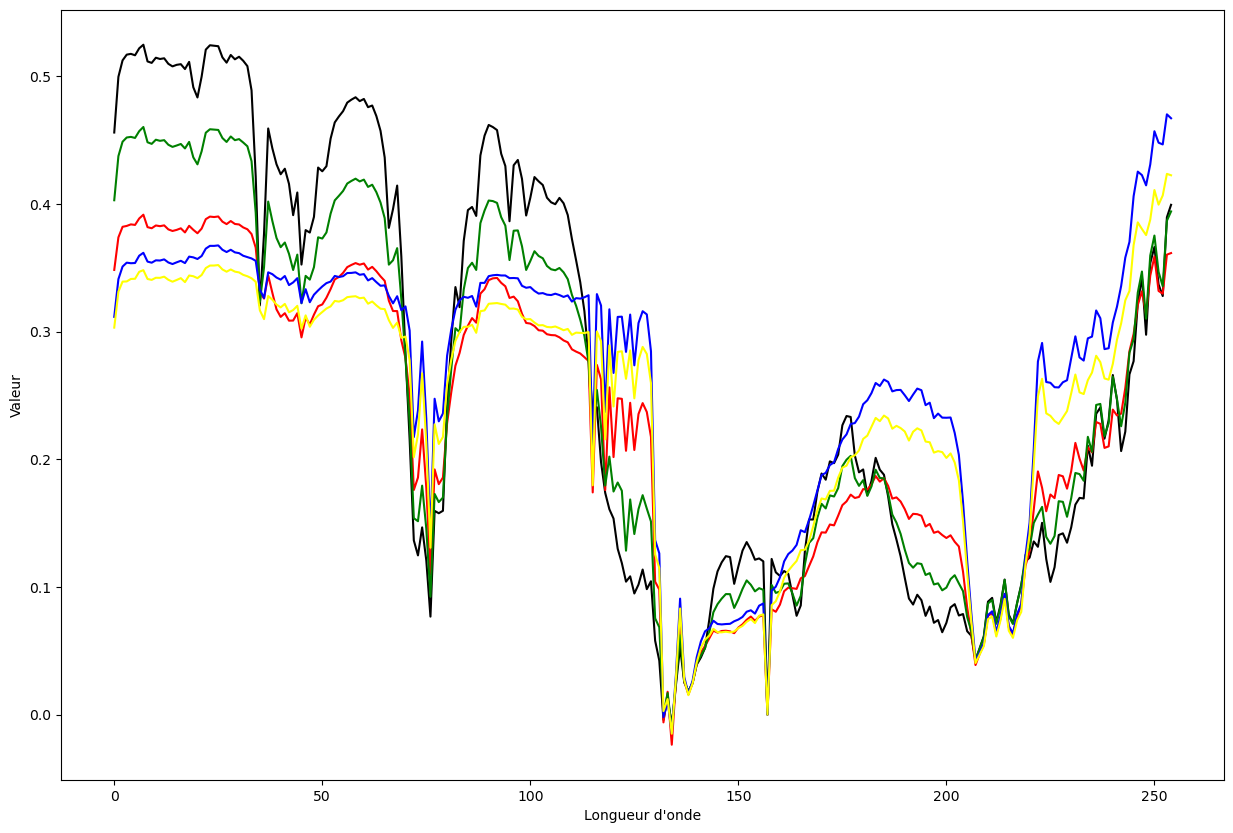

In [39]:
plt.figure(figsize = (15, 10))
x = np.arange(0, 255)
couleur=['black', 'red', 'green', 'blue', 'yellow']
for i in range(0,5):
    coul = couleur[i]
    y = np.mean(mars[classesCAH == i], axis = 0) # calcul des barycentres des classes.
    plt.plot(x, y, coul) 
plt.ylabel('Valeur')
plt.xlabel("Longueur d'onde")
plt.show()

Aquesta imatge mostra l'especte d'emissió d'ona del centroide resultant pel poceś de clustering.

### 3.4 Modèle de mélanges gaussiens
L'algorithme cherche une distribution de gaussiennes multidimensionnelles qui s'adapte le mieux à la forme des données. 

Comme pour la CAH, l'exécution de l'algorithme, ici EM (expectation minimisation) de maximisation de la log vraisemblance, est un peu longue...

In [40]:
from sklearn.mixture import GaussianMixture
# méthode GMM sur les données brutes
gmm = GaussianMixture(n_components = 5).fit(marsR)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

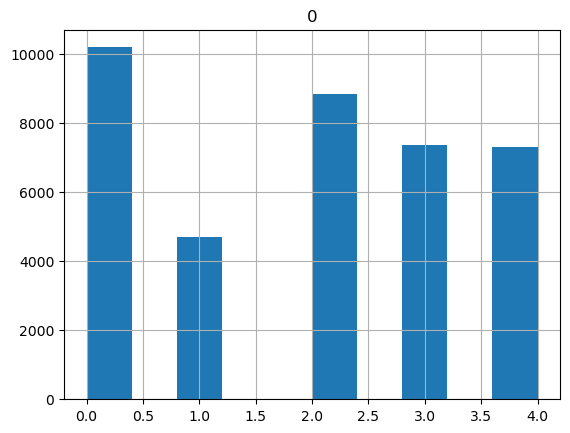

In [41]:
# identification des classes
classesGMM = gmm.predict(marsR)
# Effectifs des classes
pd.DataFrame(classesGMM).hist()

In [42]:
crossTable(classesGMM, kclasses)


max colonne [5630. 2972. 8126. 5093. 4087.]
j= [2. 1. 0. 3. 4.]



array([[5630, 1702,    0,  100, 1603],
       [4556, 2972,    0,   10,  715],
       [   0,    0, 8126,  756,  332],
       [   0,    0,  693, 5093,  578],
       [   1,   24,    8, 1414, 4087]])


max colonne [5630, 2972, 8126, 5093, 4087]
j= [2, 1, 0, 3, 4]



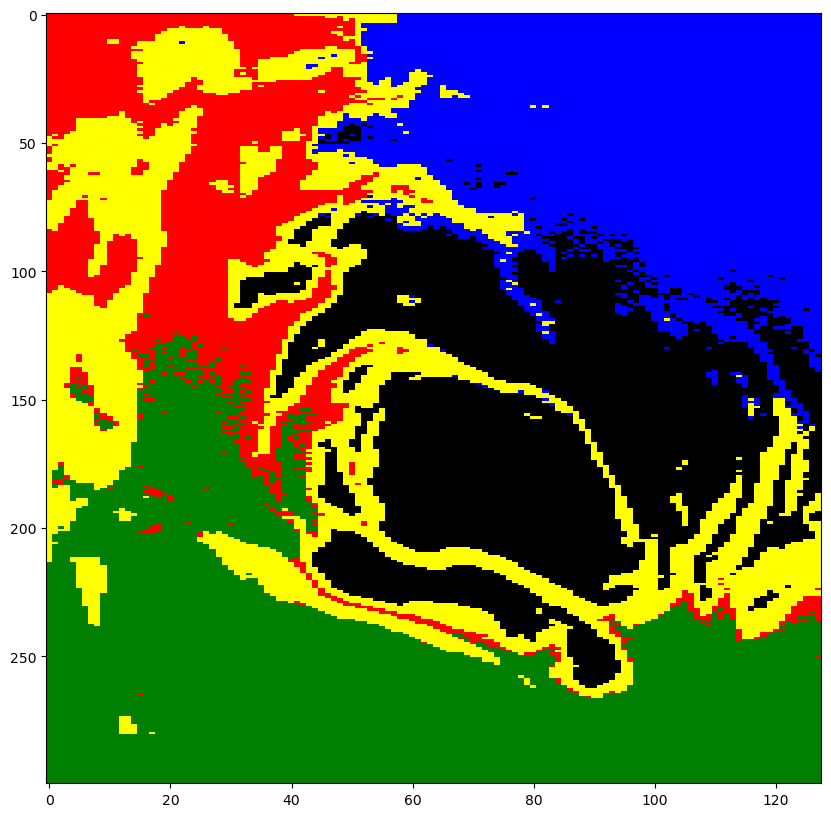

In [43]:
classesGMMcouleur = illustrationCouleur(classesGMM, kclasses)
illustration(classesGMMcouleur)

le ratio est de :
0.3253125
nb pixels classés différemment :  12492


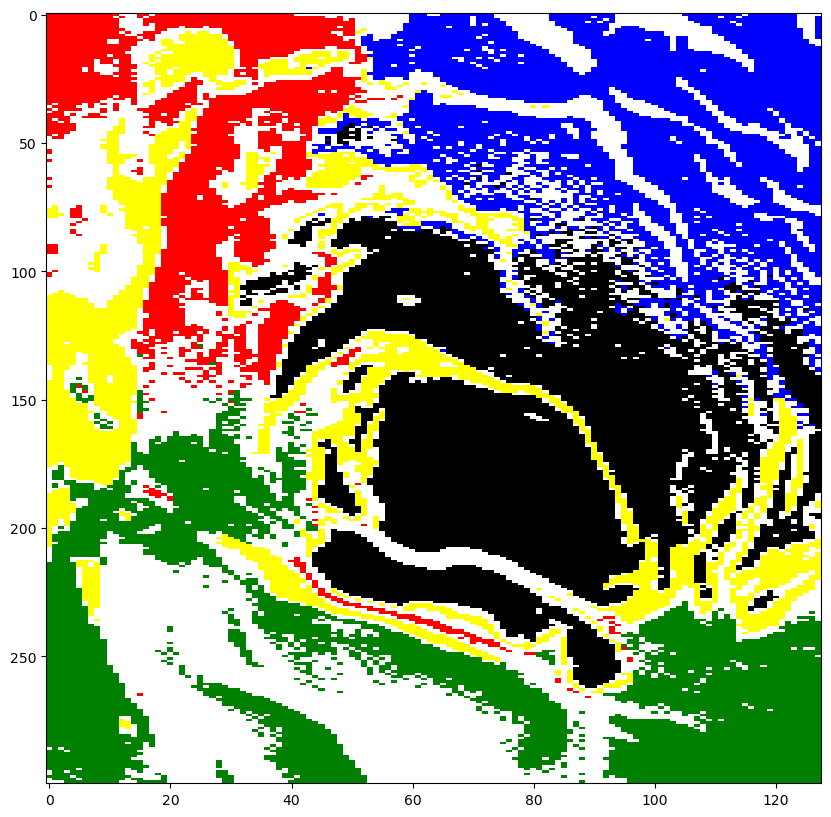

In [44]:
difference(kclasses, classesGMMcouleur)

Barycentres des classes.

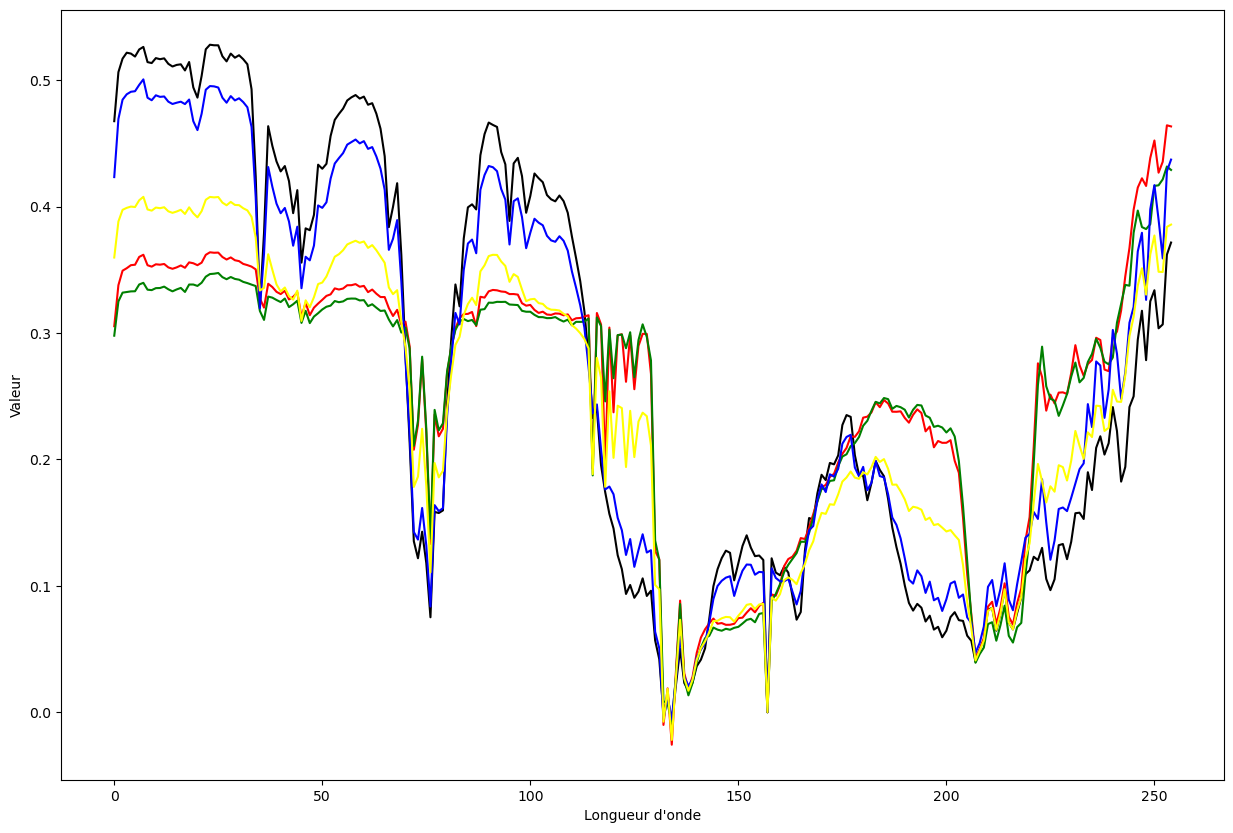

In [45]:
plt.figure(figsize = (15,10))
x = np.arange(0, 255)
couleur = ['black', 'red', 'green', 'blue', 'yellow']
for i in range(0,5):
    coul = couleur[i]
    y = np.mean(mars[classesGMMcouleur == i], axis = 0) # calcul des barycentres des classes.
    plt.plot(x, y, coul) 
plt.ylabel('Valeur')
plt.xlabel("Longueur d'onde")
plt.show()

**Q** Que dire de la comparaison entre les résultats ou segmentations fournis par ces différents algorithmes ? Un meilleur choix est-il possible ?

D'autres algorithmes pourraient être testés: DBSCAN, *affinity propagation*... consulter les documentations des librairies disponibles dont celle de [Scikit-Learn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster). 

### 3.5 Autres segmentations

Les experts proposent une image reproduite ci-dessous sur la base des mêmes données et donc évidemment pas à partir d'une *vérité terrain*.  

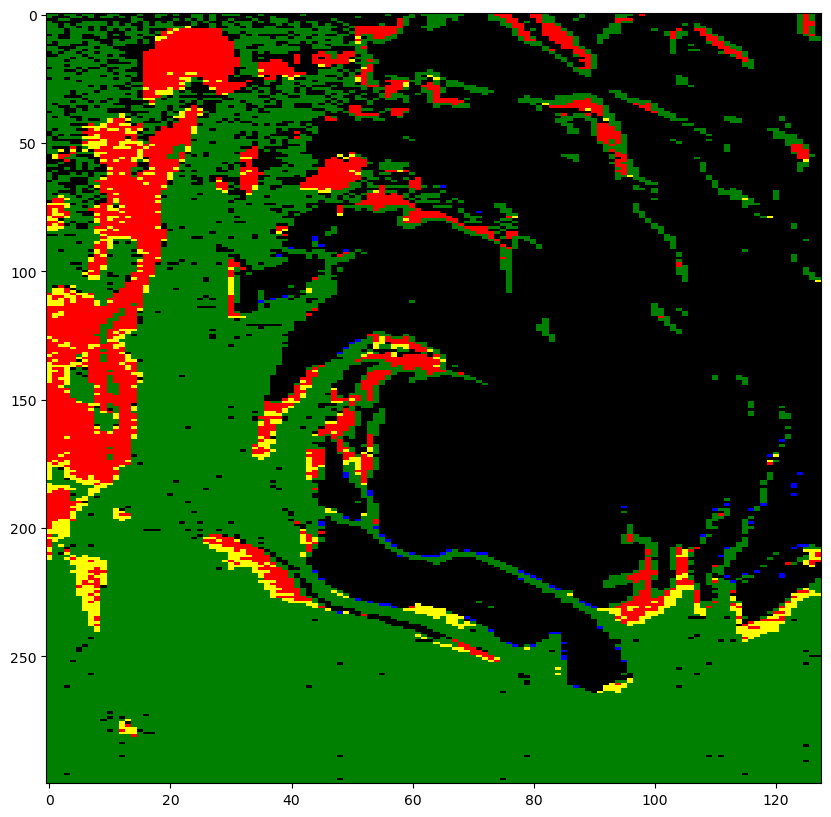

In [46]:
marsExpert = pd.read_csv("mask.csv")
marsExpert = marsExpert.values
classesExpert = np.reshape(marsExpert, 38400)
illustration(classesExpert)

Bouveyron(2017) utilise le package R `HDClassif` pout estimer les paramètres de modèles de mélanges gaussiens en lien avec une réduction de dimension. L'image obtenue est encore très différente des précédentes. Difficile de savoir si une segmentation automatique est plus appropriée qu'une autre pour retrouver ce qui pourrait être une "bonne" carte géologique de Mars. Ceci souligne toutes les difficultés de pouvoir faire des choix éclairés dans un contexe non supervisé.

**Q** Commentaire sur l'efficacité des algorithmes lorsque la taille $n$ de l'échantillon est grande.